In [162]:
import os
import cv2
import pickle
import laspy
import matplotlib.pyplot    as plt
import numpy                as np
import cupy                 as cp
import open3d               as o3d
from scipy.stats            import skew, kurtosis
from scipy.ndimage          import convolve
from cupyx.scipy.ndimage    import convolve as cpconvolve
from collections            import deque
from scipy.interpolate      import interp1d
from scipy.spatial import KDTree

In [163]:
class lidar_processor:
    def __init__(self, file_path, DBSCAN_model_path = None, window_size = 10, upsample_ratio = 2, y_shift = 0, name=None,  
                strong_PCA_threshold = 0.15, weak_PCA_threshold = 0.025, strong_edge_threshold = 80, weak_edge_threshold = 30, colourmap = 'binary',
                x_stop = 550 , box_length = 1500, xrf_window_size = 10, noise_threshold = 0.25):
        
        if DBSCAN_model_path is None:
            current_dir = os.getcwd()
            self.DBSCAN_model_path = os.path.join(current_dir, 'cluster_kd_tree.pkl')
        else: 
            self.DBSCAN_model_path = DBSCAN_model_path
             
        self.file_path = file_path
        self.colourmap = colourmap
        self.name = name if name else file_path
        self.upsample_ratio = upsample_ratio
        self.window_size = window_size
        self.strong_edge_threshold = strong_edge_threshold
        self.weak_edge_threshold = weak_edge_threshold
        self.strong_PCA_threshold = strong_PCA_threshold
        self.weak_PCA_threshold = weak_PCA_threshold
        self.y_shift = y_shift
        self.x_stop = x_stop
        self.x_start = self.x_stop + box_length
        self.noise_threshold = noise_threshold
        self.xrf_window_size = xrf_window_size

        self._build_processor()
    
    def _collect_garbage(self):
        self.tree = None
        self.labels = None
        self.correction_windows = None
        self.labeled_x_values = None
        self.gradient = None
        self.PCA_mask = None
        self.component_parameters_path = None
        self.lidar2xrf_path = None
        self.bpc_path = None
        self.intensity_path = None
        self.real_dbg_path = None
        self.lidar_dbg_path = None

    def _find_files(self):
        self.component_parameters_path = None
        self.lidar2xrf_path = None
        self.bpc_path = None
        self.intensity_path = None
        self.real_dbg_path = None
        self.lidar_dbg_path = None
        for file_name in os.listdir(self.file_path):
            full_path = os.path.join(self.file_path, file_name)
            if file_name.endswith(".component_parameters.txt"):
                self.component_parameters_path = full_path
            elif file_name.endswith(".lidar2xrf"):
                self.lidar2xrf_path = full_path
            elif file_name.endswith(".bpc"):
                self.bpc_path = full_path
            elif file_name.endswith("_intensity.png"):
                self.intensity_path = full_path
            elif file_name.endswith("real.dbg"):
                self.real_dbg_path = full_path
            elif file_name.endswith(".dbg"):
                self.lidar_dbg_path = full_path

    def _validate_files(self):
        missing_files = [
            name for name, path in {
                "bpc": self.bpc_path,
                "intensity": self.intensity_path,
                "real_dbg": self.real_dbg_path,
                "dbg": self.lidar_dbg_path,
            }.items() if path is None
        ]

        non_essential_mising_files = [
            name for name, path in {
                "component_parameters": self.component_parameters_path,
                "lidar2xrf": self.lidar2xrf_path,
            }.items() if path is None
        ]

        if missing_files:
            raise FileNotFoundError(f"Missing required files: {', '.join(missing_files)}")
        if non_essential_mising_files:
            print (f"   Missing: {', '.join(non_essential_mising_files)}, contents will be assumed")
    
    def _interpolate_x_positions(self):
        with open(self.real_dbg_path) as file:
            lines = file.readlines()

        positions = []
        table_timestamps = []

        char = '-'
        for line in lines:
            if len(line) > 40:
                if "+" in line:
                    char = '+'
                time = line.split('T')[1]
                x = float(line.split(',')[0])
                parts = time.split(':')
                t = float(parts[0]) * 3600 + float(parts[1]) * 60 + float(parts[2].split(char)[0]) 
                positions.append(x)
                table_timestamps.append(t)

        decreasing = (positions[-1] - positions[0]) < 0
        ordered_positions, ordered_timestamps = [], []

        if decreasing:
            for i in range(len(positions)-1):
                if positions[i + 1] < positions[i]:
                    ordered_positions.append(positions[i])
                    ordered_timestamps.append(table_timestamps[i])
        else:
            for i in range(len(positions)-1):
                if positions[i + 1] > positions[i]:
                    ordered_positions.append(positions[i])
                    ordered_timestamps.append(table_timestamps[i])

        ordered_positions = np.array(ordered_positions[::-1])
        ordered_timestamps = np.array(ordered_timestamps[::-1])

        min_t = np.nanmin(ordered_timestamps)

        with open(self.lidar_dbg_path) as file:
            lines = file.readlines()

            lidar_timestamps = []
            char = '-'
            for line in lines:
                if len(line) > 40:
                    time = line.split('T')[1]
                    parts = time.split(':')
                    t = float(parts[0]) * 3600 + float(parts[1]) * 60 + float(parts[2].split(char)[0]) 

                    lidar_timestamps.append(t - min_t)

        lidar_timestamps = np.array(lidar_timestamps)
        ordered_timestamps -= min_t

        ordered_timestamps = np.concatenate([ordered_timestamps[:2], ordered_timestamps[-2:]])
        ordered_positions = np.concatenate([ordered_positions[:2], ordered_positions[-2:]])

        interp_func = interp1d(ordered_timestamps, ordered_positions, kind="linear", fill_value="extrapolate", bounds_error=False) 

        self.interpolated_x_values = interp_func(lidar_timestamps)

    def _load_component_parameters(self):
        self.y_offset = 0
        if self.component_parameters_path is not None:
            with open(self.component_parameters_path) as file:
                lines = file.readlines()
                for line in lines:
                    if "XRAY_DPP[Acquisition]#0.X.Start:" in line:
                        self.x_start = float(line.split(":")[1].strip())
                    if "XRAY_DPP[Acquisition]#0.X.Stop:" in line:
                        self.x_stop = float(line.split(":")[1].strip())
                    if "XRAY_DPP[Acquisition]#0.Y.Start:" in line:
                        self.y_offset = float(line.split(":")[1].strip())
    
    def _load_lidar_data(self):
        if self.lidar2xrf_path is None:
            self.transformation_matrix = np.array([[1,0,0,192],
                                                  [0,-1,0,9.3],
                                                  [0,0,-1,53.8],
                                                  [0,0,0,1]])
        else: 
            with open(self.lidar2xrf_path) as file:
                lines = file.readlines()
                self.transformation_matrix = np.array([list(map(float, line.strip().split(","))) for line in lines])

        self.point_cloud = np.fromfile(self.bpc_path, dtype=np.float32).reshape(-1, 3)
        intensity_values = cv2.imread(self.intensity_path, cv2.IMREAD_ANYDEPTH)
        intensity_values = np.reshape(intensity_values,(-1,1))

        self.original_cloud_limits = [np.nanmax(self.point_cloud[:,0]),np.nanmin(self.point_cloud[:,0]), len(np.unique(self.point_cloud[:,0])),
                                      np.nanmax(self.point_cloud[:,1]),np.nanmin(self.point_cloud[:,1]), len(np.unique(self.point_cloud[:,1])),
                                      np.nanmax(self.point_cloud[:,2]),np.nanmin(self.point_cloud[:,2]), len(self.point_cloud[:,2])]

        self.intensity_cloud = np.hstack((self.point_cloud[:,:2], intensity_values))
        self.point_cloud = (np.hstack((self.point_cloud, np.ones((self.point_cloud.shape[0], 1)))) @ self.transformation_matrix.T)[:,:3]
        self.intensity_cloud = (np.hstack((self.intensity_cloud, np.ones((self.intensity_cloud.shape[0], 1)))) @ self.transformation_matrix.T)[:,:3]

        self.translated_cloud_limits = [np.nanmax(self.point_cloud[:,0]),np.nanmin(self.point_cloud[:,0]), len(np.unique(self.point_cloud[:,0])),
                                      np.nanmax(self.point_cloud[:,1]),np.nanmin(self.point_cloud[:,1]), len(np.unique(self.point_cloud[:,1])),
                                      np.nanmax(self.point_cloud[:,2]),np.nanmin(self.point_cloud[:,2]), len(self.point_cloud[:,2])]
    
    def _build_processor(self):
        self._find_files()
        self._validate_files()
        self._load_component_parameters()
        self._load_lidar_data()
        self._interpolate_x_positions()
        
        mask = (self.point_cloud[:,0] <= self.x_start) & (self.point_cloud[:,0] >= self.x_stop) & ((self.point_cloud[:,1]) <= (self.window_size + 5 + self.y_shift)) & ((self.point_cloud[:,1]) >=  -(self.window_size + 5 - self.y_shift))
        self.point_cloud = self.point_cloud[mask]
        self.intensity_cloud = self.intensity_cloud[mask]
        self.point_cloud[:,1] -= self.y_shift
        self.intensity_cloud[:,1] -= self.y_shift

        min_intensity = 0
        min_z = 250
        
        x_values = np.unique(self.point_cloud[:,0])
        y_values = np.unique(self.point_cloud[:,1]) 
        
        x_range = len(x_values)

        if self.upsample_ratio > 1:
            index_step = (np.nanmedian(np.diff(x_values))) / self.upsample_ratio 
            index_steps = np.arange(int(round(np.nanmin(x_values)))/index_step - 1,int(round((np.nanmax(x_values))/index_step)+1)) * index_step
            x_range = len(index_steps)
            known_indices = np.unique([np.argmin(np.abs(index_steps - x)) for x in x_values])
            unique_indices, unique_idx = np.unique(known_indices, return_index=True)
            known_indices = unique_indices
            known_x_values = x_values[unique_idx]
            all_indices = np.arange(x_range)
            interp_func = interp1d(known_indices, known_x_values, kind="linear", fill_value="extrapolate", bounds_error=False)
            x_values = interp_func(all_indices)
        else: self.upsample_ratio = 1
        
        x_value_dict = {x: index for index,x in enumerate(x_values)}
        y_value_dict = {y: index for index,y in enumerate(y_values)}

        point_array = np.full((len(y_values), x_range),np.nan)
        intensity_array = np.full((len(y_values), x_range),np.nan)
        point_dictionary = {(row[0],row[1]): (index, row[2]) for index,row in enumerate(self.point_cloud)}
        intensity_dictionary = {(row[0],row[1]): (index, row[2]) for index,row in enumerate(self.intensity_cloud)}

        for x in range (x_range):
            for y in range (len(y_values)):
                x_val = x_values[x]
                y_val = y_values[y]

                point_z = point_dictionary.get((x_val,y_val))
                intensity_z = intensity_dictionary.get((x_val,y_val))

                if point_z is not None:
                    point_array[y,x] = point_z[1]
                else:
                    point_array[y,x] = min_z
                if intensity_z is not None:
                    intensity_array[y,x] = intensity_z[1]
                else:
                    intensity_array[y,x] = min_intensity

        if self.upsample_ratio > 1:
            for y in range(len(y_values)):

                interpolated_z_values= []
                interpolated_i_values = []

                for dy in [-4,-3,-2,-1,0,1,2,3,4]:
                    y_dy = y + dy
                    if (y_dy >= 0) & (y_dy < len(y_values)):
                        known_z = point_array[y_dy,known_indices]
                        known_i = intensity_array[y_dy,known_indices]
                        known_x = x_values[known_indices]
                        mask = ~np.isnan(known_z)
                        z_interp = interp1d(known_x[mask], known_z[mask], kind='linear', fill_value="extrapolate")
                        i_interp = interp1d(known_x[mask], known_i[mask], kind='linear', fill_value="extrapolate")

                        interpolated_z_values.append(z_interp(x_values))
                        interpolated_i_values.append(i_interp(x_values))

                point_array[y, :] = np.mean(interpolated_z_values, axis=0)
                intensity_array[y, :] = np.mean(interpolated_i_values, axis=0)

        self.y_seed_point = np.argmin(np.abs(y_values))
        self.point_cloud = point_array
        self.intensity_cloud = intensity_array
        self.x_to_i_dict = x_value_dict
        self.i_to_x_list = x_values
        self.y_to_i_dict = y_value_dict
        self.i_to_y_list = y_values
        self.y_pixel_size = np.nanmedian(np.diff(y_values))
        self.x_pixel_size = np.nanmedian(np.diff(x_values))
    
    def _create_PCA_mask(self, x_window = 9, y_window = 2, batch_size = 100, **kwargs):

        y_window = int(cp.round(0.75/self.y_pixel_size))
        x_window = int(cp.round(1.5/self.x_pixel_size))

        for key, value in kwargs.items():
            if value is not None and hasattr(self, key):
                setattr(self, key, value)

        s = self.strong_PCA_threshold 
        w = self.weak_PCA_threshold 
        pc = cp.array(self.point_cloud)
        y_values = self.i_to_y_list

        y_range, x_range = 2 * y_window + 1, 2 * x_window + 1

        y_bottom = np.argmin(np.abs(y_values - self.window_size))
        y_top = np.argmin(np.abs(y_values + self.window_size))

        x_n = cp.arange(-x_window, x_window + 1) * self.x_pixel_size
        y_n = cp.arange(-y_window, y_window + 1) * self.y_pixel_size

        valid_x = cp.repeat(x_n, y_range).flatten()
        valid_y = cp.tile(y_n, x_range).flatten()
        eigvals = cp.zeros_like(pc) 
        pc = cp.pad(pc, ((y_window,y_window), (x_window,x_window)), mode='edge')

        for x in range(x_window, pc.shape[1] - x_window, batch_size):
            for y in range(y_window, pc.shape[0] - y_window, batch_size):
                batch = pc[y - y_window:y + batch_size + y_window, x - x_window:x + batch_size + x_window]

                points = cp.lib.stride_tricks.sliding_window_view(batch, (y_range, x_range))

                height, width = points.shape[:2]
                points = points.reshape(height, width, y_range * x_range)

                points = cp.stack((
                    cp.broadcast_to(valid_x, (height, width, y_range * x_range)),
                    cp.broadcast_to(valid_y, (height, width, y_range * x_range)),
                    points), axis=2)

                mean_vals = cp.mean(points[:, :, 2, :], axis=2)
                points[:, :, 2, :] -= mean_vals[..., None]

                cov_matrices = cp.einsum('...ik,...jk->...ij', points, points) / (y_range * x_range - 1)
                evals = cp.linalg.eigvalsh(cov_matrices)
                e2 = evals[:, :, 1] 

                eigvals[y - y_window:y + batch_size - y_window, x - x_window:x + batch_size - x_window] = e2 

        eigvals = cp.asnumpy(eigvals)

        eigvals[y_bottom:,:] = 0
        eigvals[:y_top,:] = 0
        neighbours = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
        strong_y, strong_x = np.where(eigvals >= s)
        weak_values = (eigvals >= w) & (eigvals < s).astype(np.uint8) 
        return_array = np.zeros_like(eigvals, dtype=cp.uint8)
        
        cp.get_default_memory_pool().free_all_blocks()

        queue = deque(zip(strong_y, strong_x))
        while queue:
            y, x = queue.popleft() 
            return_array[y, x] = 1
            for dy, dx in neighbours:
                ny, nx = y + dy, x + dx
                if 0 <= ny < weak_values.shape[0] and 0 <= nx < weak_values.shape[1]:
                    if weak_values[ny, nx]:
                        weak_values[ny, nx] = 0 
                        queue.append((ny, nx)) 
        del weak_values 

        self.PCA_mask = return_array

    def _get_gradient(self):
        array_i = cp.array(np.log(np.abs(self.intensity_cloud)), dtype=cp.float32)
        array_z = cp.array(self.point_cloud, dtype=cp.float32)
        y_values = self.i_to_y_list
        sobel_y = cp.array([
                [-20.75,],
                [ -11.6,],
                [ -6.27,],
                [    -2,],
                [     0,],
                [     2,],
                [  6.27,],
                [  11.6,],
                [ 20.75,]
        ])
        sobel_x = sobel_y.T

        y_grad_i = cp.abs(cpconvolve(array_i, sobel_y))
        x_grad_i = cp.abs(cpconvolve(array_i, sobel_x))
        magnitude_i = cp.sqrt(x_grad_i**2 + y_grad_i**2)
        y_grad_i = cp.abs(cpconvolve(array_i, sobel_y))
        magnitude_i = cp.sqrt(x_grad_i**2 + y_grad_i**2)

        x_grad_z = cp.abs(cpconvolve(array_z, sobel_y))
        y_grad_z = cp.abs(cpconvolve(array_z, sobel_x))
        magnitude_z = cp.sqrt(x_grad_z**2 + y_grad_z**2)
        y_grad_z = cp.abs(cpconvolve(magnitude_z, sobel_x))
        magnitude_z = cp.sqrt(x_grad_z**2 + y_grad_z**2)

        magnitude = cp.sqrt(magnitude_i * magnitude_z)

        y_bottom = np.argmin(np.abs(y_values - self.window_size))
        y_top = np.argmin(np.abs(y_values + self.window_size))

        magnitude[:y_top, :] = 0
        magnitude[y_bottom:, :] = 0

        self.gradient = cp.asnumpy(magnitude)
    
    def _create_edge_array(self,  **kwargs):
        for key, value in kwargs.items():
            if value is not None and hasattr(self, key):
                setattr(self, key, value)

        self._get_gradient()

        self._create_PCA_mask()


        y_values = self.i_to_y_list
        neighbours = [(-1, 0), (0, -1), (0, 1), (1, 0)]
    
        result_array = np.zeros_like(self.gradient)

        masked_gradient = self.gradient * self.PCA_mask 
        
        strong_y, strong_x = np.where(masked_gradient >= self.strong_edge_threshold)
        weak_edges = ((self.gradient >= self.weak_edge_threshold) & (masked_gradient < self.strong_edge_threshold)).astype(np.uint8) 

        queue = deque(zip(strong_y, strong_x))
        while queue:
            y, x = queue.popleft() 
            result_array[y, x] = 1
            for dy, dx in neighbours:
                ny, nx = y + dy, x + dx
                if 0 <= ny < self.gradient.shape[0] and 0 <= nx < self.gradient.shape[1]:
                    if weak_edges[ny, nx]:
                        weak_edges[ny, nx] = 0 
                        queue.append((ny, nx)) 

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
        y_top = np.argmin(np.abs(y_values - self.window_size))
        y_bottom = np.argmin(np.abs(y_values + self.window_size))
        

        result_array = cv2.morphologyEx(result_array, cv2.MORPH_CLOSE, kernel)
        result_array[y_top, :] = 1
        result_array[y_bottom, :] = 1

        self.edge_array = np.where(result_array ==  1, 1 , np.nan)

    def _get_props(self, distribution1, distribution2):
            
            properties = []
            return_properties = []

            variance =  np.var(distribution1) *((10/self.window_size)**2)
            skw = skew(distribution1)
            kurt = kurtosis(distribution1)
            mean = np.sqrt(np.mean(np.abs(distribution2)))
            max = np.sqrt(np.max(np.abs(distribution2)))

            
            properties.append(variance)
            properties.append(skw)
            properties.append(kurt)

            norm = np.linalg.norm(properties)
            
            if norm > 0:
                properties = [x / norm for x in properties]

            z = properties[0]

            return_properties.append(mean)
            return_properties.append(max)
            return_properties.append(np.abs(properties[1]))
            return_properties.append(np.arccos(z)/(np.pi/2))

            return return_properties, np.uint8(properties[1] > 0)
        
    def _load_DBSCAN_model(self):
                with open(self.DBSCAN_model_path, 'rb') as f:
                    self.tree, self.labels = pickle.load(f)

    def _define_sections(self, **kwargs):
        for key, value in kwargs.items():
            if value is not None and hasattr(self, key):
                setattr(self, key, value)

        self._load_DBSCAN_model()
        self._create_edge_array()

        convolved_point_cloud = convolve(self.point_cloud,np.array([[-1],[-2],[0],[2],[1]]))
        neighbours = [(-1, 0), (0, -1), (0, 1), (1, 0)]
        nan_mask = np.isnan(self.edge_array) 
        
        self.labeled_x_values = np.zeros(self.point_cloud.shape[1], dtype=int)

        for x in range(self.edge_array.shape[1]):
            center_x_vals = []
            avg_z_vals = {}
            avg_cz_vals = {}
            size = 0
            if nan_mask[self.y_seed_point, x]: 
                queue = deque([(self.y_seed_point, x)])
                while queue:
                    y, x = queue.popleft()
                    size += 1

                    if y == self.y_seed_point:
                        center_x_vals.append(x)

                    if y not in avg_z_vals.keys():
                        avg_z_vals[y] = []
                        avg_cz_vals[y] = []

                    avg_z_vals[y].append(self.point_cloud[y,x])
                    avg_cz_vals[y].append(convolved_point_cloud[y,x])
                    nan_mask[y, x] = False  

                    neighbors_to_add = [
                        (ny, nx) for dy, dx in neighbours
                        if (0 <= (ny := y + dy) < self.edge_array.shape[0] and 
                            0 <= (nx := x + dx) < self.edge_array.shape[1] and 
                            nan_mask[ny, nx])  
                    ]
                    queue.extend(neighbors_to_add) 
                    for ny, nx in neighbors_to_add:
                        nan_mask[ny, nx] = False
            
            if size > 5000:
                avg_z_vals = [np.nanmedian(z_values) for z_values in avg_z_vals.values()]
                avg_cz_vals = [np.nanmedian(z_values) for z_values in avg_cz_vals.values()]

                v,b = self._get_props(avg_z_vals,avg_cz_vals)
                closest_label = 0
                if not np.any(np.isnan(v)):  
                    dist, ind = self.tree.query([v], k=1)  

                    if dist[0] <= self.noise_threshold: 
                        closest_label = self.labels[ind[0]] 
                        
                        if closest_label == 2:
                            closest_label += b
                for x in center_x_vals:
                    self.labeled_x_values[x] = closest_label

    def _classify_rubble(self, x_window= 5, y_window=4, **kwargs):
        for key, value in kwargs.items():
            if value is not None and hasattr(self, key):
                setattr(self, key, value)

        pc = cp.array(self.point_cloud)
        pc = pc[self.y_seed_point - y_window:self.y_seed_point + y_window + 1,:]

        width = pc.shape[1]
        y_range, x_range = 2 * y_window + 1, 2 * x_window + 1

        x_n = cp.arange(-x_window, x_window + 1) * self.x_pixel_size
        y_n = cp.arange(-y_window, y_window + 1) * self.y_pixel_size
        valid_x = cp.repeat(x_n, y_range).flatten()
        valid_y = cp.tile(y_n, x_range).flatten()

        points = cp.lib.stride_tricks.sliding_window_view(
            cp.pad(pc, ((0,0), (x_window,x_window)), mode='edge'), (y_range, x_range)
        )

        points = points.reshape(width, y_range*x_range)

        points = cp.stack((
            cp.broadcast_to(valid_x, (width, y_range*x_range)),
            cp.broadcast_to(valid_y, (width, y_range*x_range)),
            points), axis=2)
        mean_vals = cp.mean(points[:,:,2], axis=(1), keepdims=True)
        points[:,:,2] -= mean_vals

        cov_matrices = cp.matmul(points.transpose(0,2,1), points) / (y_range * x_range - 1)

        eigvals, eigvecs = cp.linalg.eigh(cov_matrices)

        eigvecs = eigvecs[:, :, 0]

        eigvals = eigvals[:,0]/(eigvals[:,0] + eigvals[:,1]  + eigvals[:,2]) 
        
        x_offset = cp.abs(cp.arctan(eigvecs[:,0]/eigvecs[:,2]))
        y_offset = cp.abs(cp.arctan(eigvecs[:,1]/eigvecs[:,2]))

        results = {self.i_to_x_list[i]: [self.labeled_x_values[i],float(eigvals[i]),float(x_offset[i]),float(y_offset[i])] for i in range(len(self.i_to_x_list))}

        cp.get_default_memory_pool().free_all_blocks()
 
        self.rubble_classifications = results
   
    def _define_correction_windows(self, **kwargs):
        for key, value in kwargs.items():
            if value is not None and hasattr(self, key):
                setattr(self, key, value)

        self._define_sections()
        self._classify_rubble()

        windows = {}

        for x_start in np.arange(0, np.nanmax(self.i_to_x_list), self.xrf_window_size):
            values = [self.rubble_classifications[i] for i, x in zip(self.i_to_x_list, self.i_to_x_list) 
            if x_start <= x < x_start + self.xrf_window_size]
            if values:
                values = np.array(values)
        
                x_end = max(x for x in self.i_to_x_list if x_start <= x < x_start + self.xrf_window_size)
                x_start = min(x for x in self.i_to_x_list if x_start <= x < x_start + self.xrf_window_size)
            
                
                half_perc = np.sum(values[:,0] == 1) / len(values)
                empty_perc = np.sum(values[:,0] == 2) / len(values)
                full_perc = np.sum(values[:,0] == 3) / len(values)

                rubble_perc = 1 - half_perc - empty_perc - full_perc

                avg_var = np.nanmean(values[:, 1])
                avg_x_offset = np.nanmean(values[:, 2])
                avg_y_offset = np.nanmean(values[:, 3])

                windows[(x_start, x_end)] = [half_perc, full_perc, empty_perc, rubble_perc, avg_var, avg_x_offset, avg_y_offset]

        self.correction_windows = windows

    def _save_correction_windows(self, **kwargs):
        for key, value in kwargs.items():
            if value is not None and hasattr(self, key):
                setattr(self, key, value)
        
        self._define_correction_windows()
        
        os.makedirs(self.file_path, exist_ok=True)
        
        file_path = os.path.join(self.file_path, 'rubble_classification.pkl')
        
        with open(file_path, 'wb') as f:
            pickle.dump(self.correction_windows, f)

    def _plot_correction_windows(self, width = 150, height = 7, dpi = 75, plot_point_cloud = False, **kwargs):
        
        for key, value in kwargs.items():
            if value is not None and hasattr(self, key):
                setattr(self, key, value)

        self._define_correction_windows()


        fig, ax = plt.subplots(figsize=(width, height), dpi=dpi)

        colormap = ["green", "blue", "purple", "red"]
        cmap1 = plt.cm.cool  
        cmap2 = plt.cm.cool

        all_vars = []
        x_angles = []
        y_angles = []

        for values in self.correction_windows.values():
            var, x_angle, y_angle = values[4:7]
            all_vars.append(var)
            x_angles.append(x_angle)
            y_angles.append(y_angle)

        min_var = np.nanmin(all_vars)
        max_var = np.nanmax(all_vars)
        min_x_angle = np.nanmin(x_angles)
        max_x_angle = np.nanmax(x_angles)
        min_y_angle = np.nanmin(y_angles)
        max_y_angle = np.nanmax(y_angles)

        if plot_point_cloud:
            display = self.point_cloud
        else:
            display = self.intensity_cloud
        ax.imshow(cp.flipud(display), cmap=self.colourmap, interpolation='nearest', alpha=1, aspect= 'auto')

        for (x_start, x_end), values in self.correction_windows.items():
            half_perc, empty_perc, full_perc, rubble_perc = values[:4]

            ratios = np.array([half_perc, empty_perc, full_perc, rubble_perc])
            ratios /= ratios.sum()  

            start_i = int(np.where(self.i_to_x_list == x_start)[0][0])
            end_i = int(np.where(self.i_to_x_list == x_end)[0][0])
            width = end_i - start_i + 1
            bar_heights = ratios * 12  
            bottoms = self.y_seed_point - 6 + np.insert(np.cumsum(bar_heights[:-1]), 0, 0)

            for j in range(4):
                ax.bar(start_i, height=bar_heights[j], width=width,
                    bottom=bottoms[j], color=colormap[j], alpha=1, align = 'edge')

            var, x_angle, y_angle = values[4:]
            norm1 = plt.Normalize(vmin=min_var, vmax=max_var)
            norm2 = plt.Normalize(vmin=min_x_angle, vmax=max_x_angle)
            norm3 = plt.Normalize(vmin=min_y_angle, vmax=max_y_angle)
            color1 = cmap1(norm1(var))
            color2 = cmap2(norm2(x_angle))
            color3 = cmap2(norm3(y_angle))
            extra_heights = 7.5

            ax.bar(start_i, height=extra_heights, width=width,
                bottom=0, color=color1, align = 'edge')
            ax.bar(start_i, height=extra_heights, width=width,
                bottom=extra_heights, color=color2, align = 'edge')
            ax.bar(start_i, height=extra_heights, width=width,
                bottom=extra_heights*2, color=color3, align = 'edge')

        ax.set_xlabel("X index",fontsize = 20)
        ax.set_ylabel("Y index",fontsize = 20)
        ax.set_xlim(0, display.shape[1])
        ax.set_title(self.name, fontsize=35)

        plt.show()

    def _plot_gradient(self,width = 150, height = 7, dpi = 75, **kwargs):

        for key, value in kwargs.items():
            if value is not None and hasattr(self, key):
                setattr(self, key, value)
        
        self._get_gradient()
            
        fig, ax = plt.subplots(figsize=(width, height), dpi=dpi)
        ax.imshow(cp.flipud(self.gradient), cmap='nipy_spectral_r', interpolation='nearest', alpha = 1, aspect = 'auto')
        ax.set_xlabel("X index",fontsize = 20)
        ax.set_ylabel("Y index",fontsize = 20)
        ax.set_title(self.name, fontsize=35)
        plt.show()
    
    def _plot_edges(self,width = 150, height = 7, dpi = 75, **kwargs):

        for key, value in kwargs.items():
            if value is not None and hasattr(self, key):
                setattr(self, key, value)

        self._create_edge_array()
            
        fig, ax = plt.subplots(figsize=(width, height), dpi=dpi)
        ax.imshow(cp.flipud(self.edge_array), cmap='nipy_spectral', interpolation='nearest', alpha = 1, aspect = 'auto')
        ax.set_xlabel("X index",fontsize = 20)
        ax.set_ylabel("Y index",fontsize = 20)
        ax.set_title(self.name, fontsize=35)
        plt.show()

    def _plot_PCA_mask(self, width = 150, height = 7, dpi = 75, **kwargs):

        for key, value in kwargs.items():
            if value is not None and hasattr(self, key):
                setattr(self, key, value)



        self._create_PCA_mask()

        fig, ax = plt.subplots(figsize=(width, height), dpi=dpi)
        a = 1

        ax.imshow(cp.flipud(self.PCA_mask), cmap='nipy_spectral', interpolation='nearest', alpha = a, aspect = 'auto')
        ax.set_xlabel("X index")
        ax.set_ylabel("Y index")
        ax.set_title(self.name)
        plt.show()

    def _plot_sections(self, plot_point_cloud = False, plot_intensity_cloud = True, width = 150, height = 7, dpi = 75, **kwargs):

        for key, value in kwargs.items():
            if value is not None and hasattr(self, key):
                setattr(self, key, value)

        self._create_edge_array()
        
        sections = self.edge_array.copy()
    
        neighbours = [(-1, 0), (0, -1), (0, 1), (1, 0)]  
        nan_mask = np.isnan(sections)  

        int = 2
        for x in range(sections.shape[1]):
            if nan_mask[self.y_seed_point, x]: 
                queue = deque([(self.y_seed_point, x)])
                while queue:
                    y, x = queue.popleft()
                    sections[y, x] = int 
                    nan_mask[y, x] = False  
                    neighbors_to_add = [(ny, nx) for dy, dx in neighbours
                        if (0 <= (ny := y + dy) < sections.shape[0] and 
                            0 <= (nx := x + dx) < sections.shape[1] and nan_mask[ny, nx])]
                    queue.extend(neighbors_to_add) 
                    for ny, nx in neighbors_to_add:
                        nan_mask[ny, nx] = False 
            int += 1
        
        sections = np.where(sections > 1, sections, np.nan)

        fig, ax = plt.subplots(figsize=(width, height), dpi=dpi)
        a = 1
        if plot_point_cloud:
            ax.imshow(cp.flipud(self.point_cloud), cmap=self.colourmap, interpolation='nearest', alpha = 1, aspect= 'auto')
            a = 0.5
        if plot_intensity_cloud:
            ax.imshow(cp.flipud(self.intensity_cloud), cmap=self.colourmap, interpolation='nearest', alpha = 1, aspect= 'auto')
            a = 0.5
        ax.imshow(cp.flipud(sections), cmap='nipy_spectral', interpolation='nearest', alpha = a, aspect= 'auto')
        ax.set_xlabel("X index")
        ax.set_ylabel("Y index")
        ax.set_title(self.name)
        plt.show()

    def _view_point_cloud(self, intensity_cloud = False):

        x = (list)(self.i_to_x_list) * len(self.i_to_y_list)
        y = np.repeat(self.i_to_y_list, len(self.i_to_x_list))

        if intensity_cloud:
            z  = self.intensity_cloud.flatten()
        else:
            z = self.point_cloud.flatten()

        pcd = o3d.geometry.PointCloud()
        points = np.column_stack((x, y, -z))
        pcd.points = o3d.utility.Vector3dVector(points)
        
        o3d.visualization.draw_geometries([pcd])

    def _plot_point_cloud(self,width = 150, height = 7, dpi = 75):

        fig, ax = plt.subplots(figsize=(width, height), dpi=dpi)
        ax.imshow(cp.flipud(self.point_cloud), cmap=self.colourmap, interpolation='nearest', alpha = 1, aspect = 'auto')
        ax.set_xlabel("X index")
        ax.set_ylabel("Y index")
        ax.set_title(self.name)

        plt.show()

    def _plot_intensity_cloud(self,width = 150, height = 7, dpi = 75):

        fig, ax = plt.subplots(figsize=(width, height), dpi=dpi)
        ax.imshow(cp.flipud(self.intensity_cloud), cmap=self.colourmap, interpolation='nearest', alpha = 1, aspect = 'auto')
        ax.set_xlabel("X index")
        ax.set_ylabel("Y index")
        ax.set_title(self.name)

        plt.show()

    def _get_data_cube(self):

        x = (list)(self.i_to_x_list) * len(self.i_to_y_list)
        y = np.repeat(self.i_to_y_list, len(self.i_to_x_list))
        z = self.point_cloud.flatten()

        return np.column_stack((x, y, z))

    def _save_to_las(self):

        x = (list)(self.i_to_x_list) * len(self.i_to_y_list)
        y = np.repeat(self.i_to_y_list, len(self.i_to_x_list))
        z = self.point_cloud.flatten()

        file_path = os.path.join(self.file_path, "point_cloud_trimmed.las")

        header = laspy.LasHeader(point_format=1, version="1.2") 
        las = laspy.LasData(header)

        las.x = np.array(x)
        las.y = np.array(y)
        las.z = np.array(z)

        las.write(file_path)

    def _print_scan_limits(self, translated = True):
        if translated:
            data = self.original_cloud_limits
            data[0] = data[0] * self.transformation_matrix[0,0] + self.transformation_matrix[0,3]
            data[1] = data[1] * self.transformation_matrix[0,0] + self.transformation_matrix[0,3]
            data[3] = data[3] * self.transformation_matrix[1,1] + self.transformation_matrix[1,3]
            data[4] = data[4] * self.transformation_matrix[1,1] + self.transformation_matrix[1,3]
            data[6] = data[6] * self.transformation_matrix[2,2] + self.transformation_matrix[1,3]
            data[7] = data[7] * self.transformation_matrix[2,2] + self.transformation_matrix[2,3]
            print(f"limits in machine coordinates for {self.name}:")
        else:
            data = self.original_cloud_limits
            print(f"limits in lidar coordinates for {self.name}:")

        print(f" x value range: {data[0]}mm to {data[1]}mm, number of lines in the x direction: {data[2]}")
        print(f" y value range: {data[3]}mm to {data[4]}mm, number of lines in the y direction: {data[5]}")
        print(f" z value range: {data[6]}mm to {data[7]}mm, total number of points: {data[8]}")
        print(f"pixel size: {self.x_pixel_size}mm in the x direction, {self.y_pixel_size}mm in the y direction")

In [178]:

root_dir = r"C:\Users\eashenhurst\Desktop\local scans\test_csv_core"
filter = ""

paths_list = []
for root, dirs, files in os.walk(root_dir):
        for dir_name in dirs:
            if dir_name.startswith("Core"):
                folder = os.path.join(root,dir_name)
                if filter in folder:
                    paths_list.append(folder)


processors = []
i = 0
for folder in paths_list:
        i = 4
        try:
            processor = lidar_processor(folder, name = (folder.split('\\')[-1] + f" upsample_ratio = 4"), 
                                       window_size= 10)
        except FileNotFoundError as e:
            print(f"   Error: {e}")
        else:  
            processors.append(processor)
            print(processor.name)

print(f"{len(processors)} Lidar Processors created") 

   Missing: lidar2xrf, contents will be assumed
Core_000_Box_073_of_073_Part_1_of_5 upsample_ratio = 4
   Missing: lidar2xrf, contents will be assumed
Core_000_Box_073_of_073_Part_2_of_5 upsample_ratio = 4
   Missing: lidar2xrf, contents will be assumed
Core_000_Box_073_of_073_Part_3_of_5 upsample_ratio = 4
   Missing: lidar2xrf, contents will be assumed
Core_000_Box_073_of_073_Part_4_of_5 upsample_ratio = 4
   Missing: lidar2xrf, contents will be assumed
Core_000_Box_073_of_073_Part_5_of_5 upsample_ratio = 4
5 Lidar Processors created


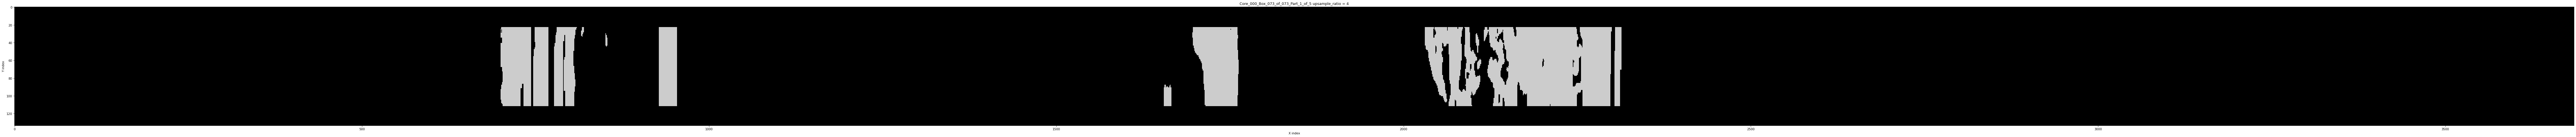

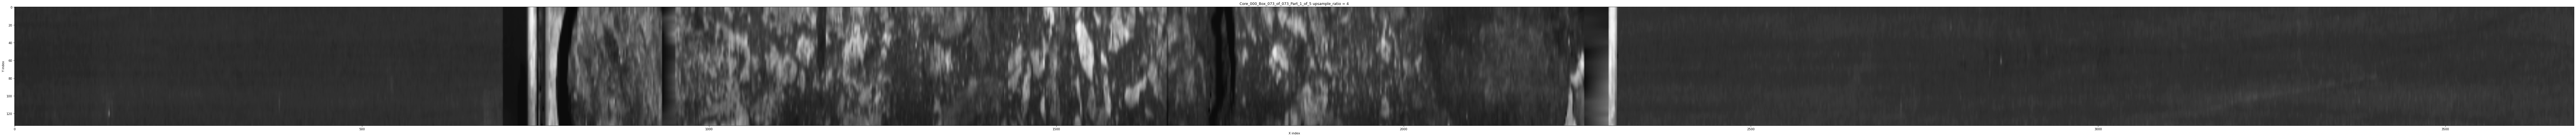

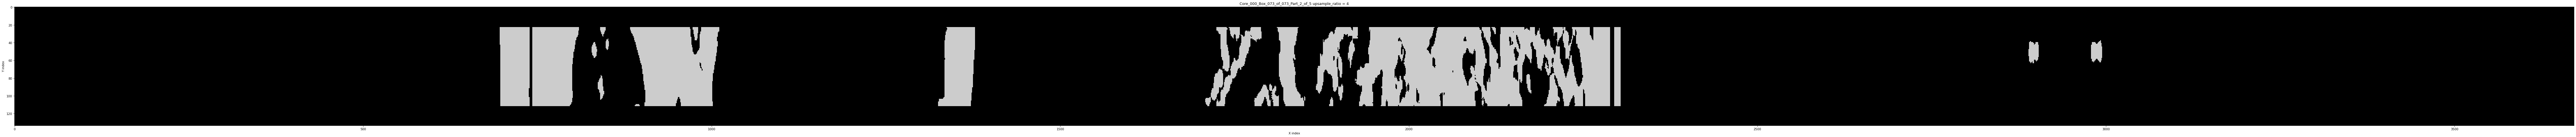

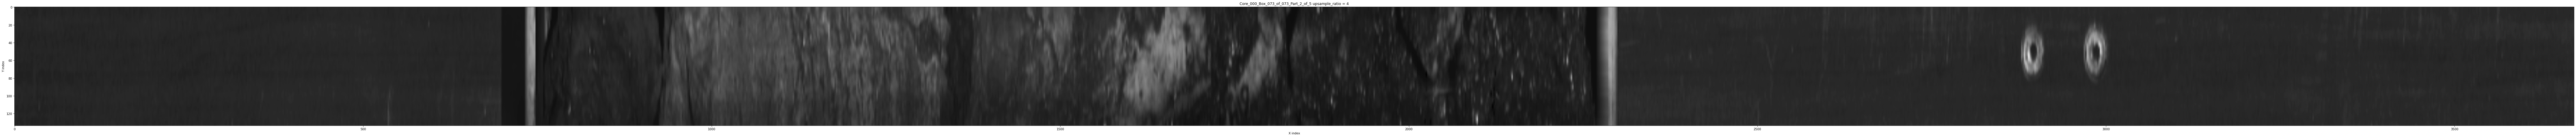

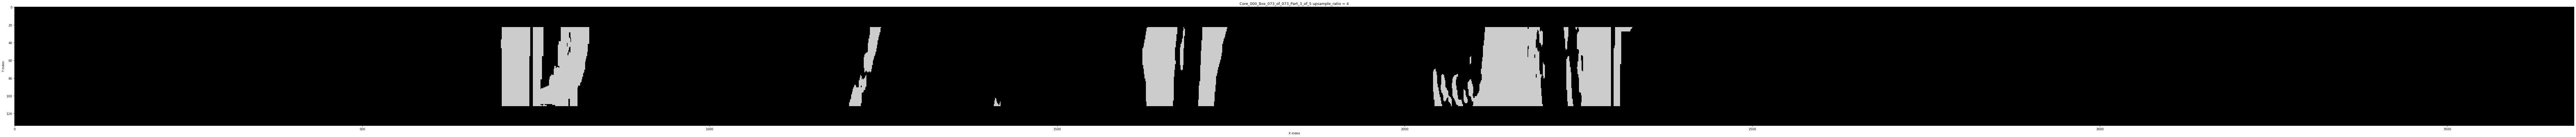

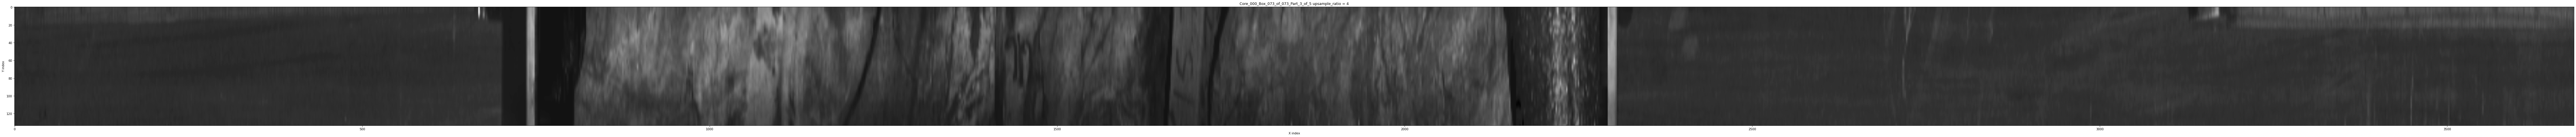

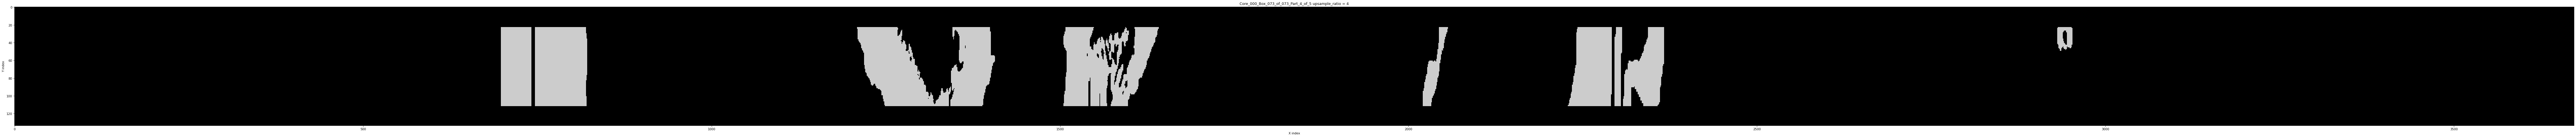

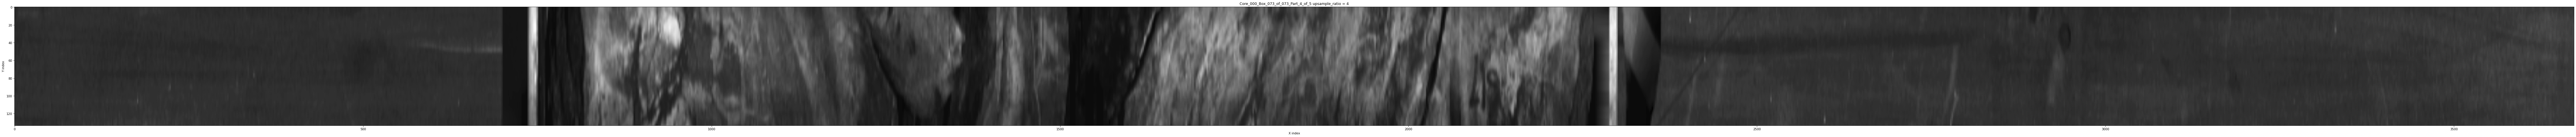

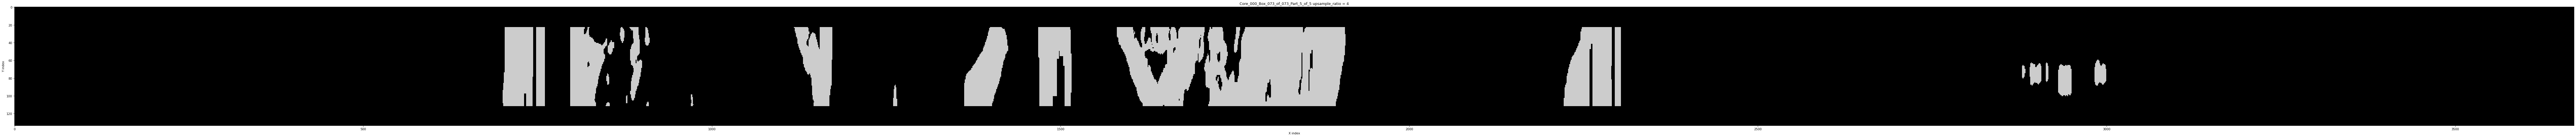

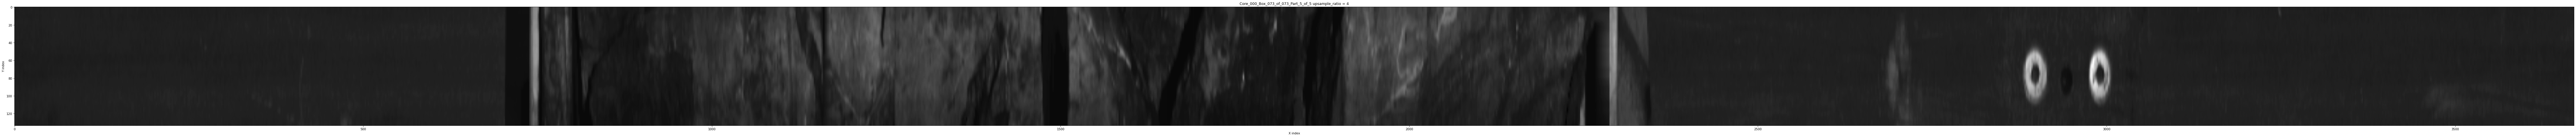

In [181]:
for LP in processors:
    LP._plot_PCA_mask(strong_PCA_threshold = 0.22, weak_PCA_threshold = 0.2075)
    LP._plot_intensity_cloud()